# 机器学习毕业项目--猫狗大战

沈平岗
2019年1月22日

# I.项目说明

包括项目的要求、项目概述、问题叙述、评论指标的相关说明

## 项目要求

项目要求：使用深度学习方法识别一张图片是猫还是狗

输入：一张彩色图片

输出：是猫还是狗

## 项目概述

  本项目将使用卷积神经网络（Convolutional Neural Networks, CNN）为模型。卷积神经网络是是一类包含卷积计算且具有深度结构的前馈神经网络（Feedforward Neural Networks），是深度学习（deep learning）的代表算法之一。对卷积神经网络的研究始于二十世纪80至90年代，时间延迟网络和LeNet-5是最早出现的卷积神经网络；在二十一世纪后，随着深度学习理论的提出和数值计算设备的改进，卷积神经网络得到了快速发展，并被大量应用于计算机视觉、自然语言处理等领域。

本项目采用kaggle 提供数据集。使用keras构建模型进行训练，对测试数据进行分类。并将最终结果上传到kaggle 进行最终评分。

项目中会运用迁移学习提高学习精度。主要使用resnet50，xception，inceptionV3 提取特征向量，通过提取的特征向量构建神经网络进行训练。

项目同时会采用部署网页应用，采用Flask搭建一个简单的图像识别应用。通过上传图片，识别图片中动物的类型。是猫还是狗。

数据集下载地址：https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data


## 问题叙述

数据集中异常图片的剔除。数据集中存在部分异常图片或模糊不清、分辨率不高的图片。在训练数据中需要识别并进行删除。

训练数据集中。train目录中以 type.num.jpg 做为文件名，如：dog.11956.jpg 。在keras中，不同类型的图片需要用不同目录名进行存放。

图片大小处理。提供的数据集中图片大小各不相同，在做网络训练时需要对图片大小做处理。

## 评价指标

交叉熵（cross entropy）是深度学习中常用的一个概念，一般用来求目标与预测值之间的差距。是分类问题中广泛使用的一种损失函数。

该项目是一个二分类问题，因此可以采用 logloss 损失函数作为评价指标。其公式如下：

$$LogLoss = -\frac{1}{n}\sum_{i=1}^{n}[y_ilog(\hat{y_i}) + (1 - y_i)log(1 - \hat{y_i})]$$

交叉熵损失越小，代表模型的性能越好。采用交叉熵作为损失函数可以有效的解决梯度消失和梯度爆炸的问题。


# II.项目分析

项目分析中主要包含对数据的探索、探索性可视化、算法和技术、基准模型

## 数据的探索

下载的kaggle数据集中解压后包含3个文件：train.zip、test.zip、sample_submission.csv 。

其中：

train.zip 为训练数据集。包含了猫和狗的训练数据集合。总共 25,000 图片

test.zip 为测试数据。没有标定图片是猫、还是狗。以数字命名，从1开始。总共 12,500 图片

sample_submission.csv 为提交样本。需要将测试数据集的结果导入到样本中，然后提交给kaggle、其中预测为狗则为1、猫为0.

## 数据可视化

1.可视化当前训练数据集中猫、狗的数量。测试数据和正式数据的数量。

2.随机选取部分图片进行查看和预览

In [1]:
# 导入相关库
import os
import cv2
import numpy as np
from keras.preprocessing import image  
from matplotlib import pyplot as plt

%matplotlib inline

Using TensorFlow backend.


In [2]:
# 定义当前数据集所在的路径(绝对路径)
train_dir = '/data/dogs_vs_cats/data/train/'
test_dir = '/data/dogs_vs_cats/data/test/'

# 输出train数据集中 cat 和 dog 各自的图片数量
cat_counts = 0
dog_counts = 0
for file_name in os.listdir(train_dir):
    # 如果是目录则跳过
    path = os.path.join(train_dir,file_name)
    if os.path.isfile(path):
        if file_name[:3] == 'cat':
            cat_counts += 1
        elif file_name[:3] == 'dog':
            dog_counts += 1

print("cat images : {}".format(cat_counts))
print("dog images : {}".format(dog_counts))

# 定义 train 数据集中图片的数量
train_images_counts = 25000 
# 定义 test 数据集中图片的数量
test_images_counts = 12500

cat images : 12500
dog images : 12500


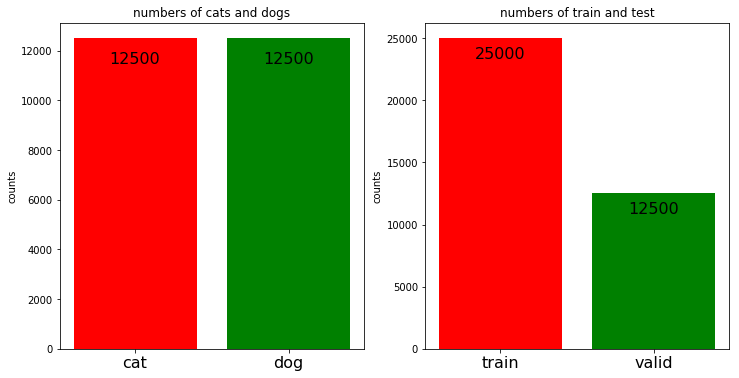

In [3]:
# 绘制统计图
plt.figure(figsize=(12,6))

# 绘制train数据集中猫和狗各自的数量
plt.subplot(1,2,1)
plt.bar(np.arange(1,3),[cat_counts,dog_counts],color='rgb')
plt.text(1,cat_counts-1000,str(cat_counts),fontsize=16,ha='center')
plt.text(2,dog_counts-1000,str(dog_counts),fontsize=16,ha='center')
plt.xticks(np.arange(1,3), ['cat','dog'],fontsize=16)
plt.ylabel("counts")
plt.title("numbers of cats and dogs")

# 绘制train和test数据集中各自的图片数量
plt.subplot(1,2,2)
plt.bar(np.arange(1,3),[train_images_counts,test_images_counts],color='rgb')
plt.text(1,train_images_counts-1600,str(train_images_counts),fontsize=16,ha='center')
plt.text(2,test_images_counts-1600,str(test_images_counts),fontsize=16,ha='center')
plt.xticks(np.arange(1,3), ['train','valid'],fontsize=16)
plt.ylabel("counts")
plt.title("numbers of train and test")

plt.show()

由统计图可以看出，当前提供的数据集中，train数据集中猫和狗的图片数量一样，都是12500。（当前未做数据预处理）

In [4]:
# 根据提供的图片，转换成可以在matplotlib显示的对象

def cv_read_image(img_path):
    '''input : <image_path> 图片的绝对路径
       return : 可在matplotlib中显示的图片对象
    '''
    # 加载图片
    img = cv2.imread(img_path)
    # 将opencv中的BGR、GRAY格式转换为RGB，使matplotlib中能正常显示opencv的图像 并返回
    return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

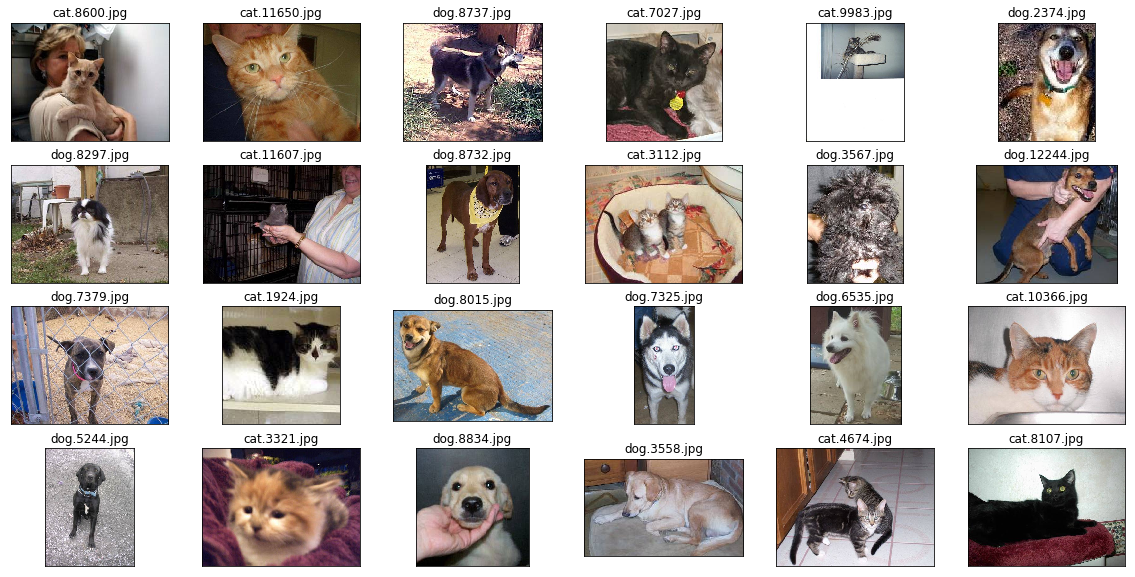

In [5]:
# 随机选取一定数量的图片进行查看

# 生成随机数
random_img_index = np.random.choice(train_images_counts,24)

# 对随机生成的图片进行转换
random_img = list()
image_name = list()
for index in random_img_index:
    name = os.listdir(train_dir)[index]
    img_path = os.path.join(train_dir,name)
    img = cv_read_image(img_path)
    random_img.append(img)
    image_name.append(name)

# 显示随机选取的图片
fig = plt.figure(figsize=(20,10))
for i in range(len(random_img)):
    ax = fig.add_subplot(4,6,i+1,xticks=[],yticks=[])
    ax.imshow(random_img[i])
    ax.set_title(image_name[i])
    
plt.show()

可视化中显示的图片，可以发现图片的大小各不相同，同时有的图片存在难以分辨的问题。

根据观察，train 数据集中还同时存在部分异常图片。如以下找出的异常图片。

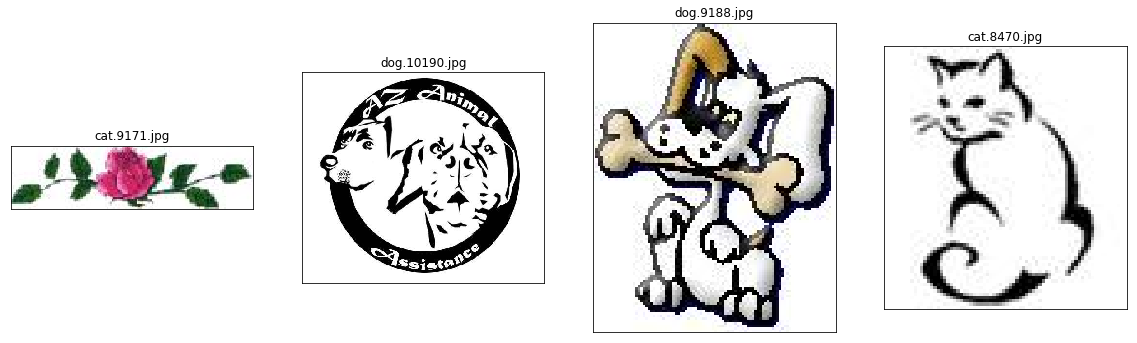

In [6]:
# 定义发现的几张异常图片
abnormal_picture = ["cat.9171.jpg",'dog.10190.jpg','dog.9188.jpg','cat.8470.jpg']

# 获取图片路径
abnormal_picture_path = [os.path.join(train_dir,name) for name in abnormal_picture]

# 显示图片
abnormal_picture_obj = [cv_read_image(image_path) for image_path in abnormal_picture_path]
fig = plt.figure(figsize=(20,10))
for i in range(len(abnormal_picture_obj)):
    ax = fig.add_subplot(1,4,i+1,xticks=[],yticks=[])
    ax.imshow(abnormal_picture_obj[i])
    ax.set_title(abnormal_picture[i])

这里通过人眼观察发现的几张异常图片，当然实际中可能不止这几张。异常图片剔除将在数据预处理中进行发现和处理。

## 算法和技术

### 神经网络

人工神经网络（Artificial Neural Networks，简写为ANNs）也简称为神经网络（NNs）或称作连接模型（Connection Model），它是一种模仿动物神经网络行为特征，进行分布式并行信息处理的算法数学模型。这种网络依靠系统的复杂程度，通过调整内部大量节点之间相互连接的关系，从而达到处理信息的目的。神经网络基于神经元或节点的集合。可模拟为生物大脑的神经元，每个连接，如生物大脑中的突触，可以将信号从一个人工神经元传递到另一个人工神经元。接收信号的人工神经元可以处理它，然后发信号通知与之相连的其他人工神经元。如下图：
![title](images/Neuron3.png)

人工神经网络方法的最初目标是以与人类大脑相同的方式解决问题。然而，随着时间的推移，注意力转移到执行特定任务，导致偏离生物学。人工神经网络已经用于各种任务，包括计算机视觉，语音识别，机器翻译，社交网络过滤，游戏板和视频游戏以及医学诊断。人工神经网络是一个相互关联的组节点，类似的庞大网络的神经元在大脑。这里，每个圆形节点代表人造神经元，箭头代表从一个人造神经元的输出到另一个人造神经元的输入的连接，主要包括三个层级：输入层、输出层、隐藏层。如下图：
![title](images/Neuron2.png)

对于猫狗识别属于分类问题。算法的输入是由图片每一个像素组成的特征向量，输出是类别，即猫、还是狗。

(图片来自于网络)

### 卷积神经网络

卷积神经网络（Convolutional Neural Networks, CNN）是一类包含卷积计算且具有深度结构的前馈神经网络（Feedforward Neural Networks）.其实卷积神经网络依旧是层级网络，只是层的功能和形式做了变化，可以说是传统神经网络的一个改进。卷积神经网络的出现，意味着可以从图片中找到更多的特征信息。

#### 卷积神经网络模型：
卷积神经网络包含：卷积层、激励函数、池化层、全连接层。
![title](images/CNN.png)

#### 卷积神经网络层级：
##### 卷积层
卷积层的功能是对输入数据进行特征提取，其内部包含多个卷积核，组成卷积核的每个元素都对应一个权重系数和一个偏差量，类似于一个前馈神经网络的神经元。
##### 池化层
池化层用于特征降维，在一定程度上防止过拟合。可以理解为如果输入是图像的话，那么池化层的最主要作用就是压缩图像。

##### 激励函数
对输出结果做非线性映射。CNN采用的激励函数一般为ReLU，它的特点是收敛快，防止梯度消失。

##### 全连接层
通常全连接层在卷积神经网络尾部。也就是跟传统的神经网络神经元的连接方式是一样的。


### 模型选择及技术

自2012年的ImageNet 比赛起，诞生了许多优秀的网络结构。其中被认可为比较优异的有：VGG，ResNet,Inception，AlexNet 等等。具体的准确表现如下图：
![title](images/Imagenet.png)

综合分析，每种网络模型的准确度各有不同。由于项目采用keras完成，keras支持使用迁移学习的网络模型ResNet50、VGG16、VGG19、InceptionV3、Xception。综合考虑项目采用 ResNet50 为迁移学习的基础模型，先使用resnet50提取特征向量，并构建神经网络模型进行训练。

#### ResNet 网络模型
ResNet(Residual Neural Network) 在2015年被提出，在ImageNet比赛classification任务上获得第一名，在Top5上的错误率为3.75%，同时参数数量比VGGNet低，由于Resnet的结构，极快的加速神经网络的训练，模型的准确率也有比较大的提升。因为它“简单与实用”并存，之后很多方法都建立在ResNet50或ResNet101的基础上完成的，检测，分割。

ResNet 的主要思想是在网络中添加直连通道，即Highway Network 的思想。对比此前的网络结构是做一个非线性变换，而Highway Network 则允许保留之前网络层一定比例的输出，允许原始输入信息之间传到后面的层中。如下图：
![title](images/ResNet0.png)

在 ResNet 网络结构中会用到两种残差模块，一种是以两个3*3的卷积网络串联在一起做为残差模块，另一种是1*1，3*3，1*1的3个卷积网络串联在一起做为一个残差模块。结构图如下：
![title](images/ResNet3.png)

ResNet 有不同的网络层数，比较常用的是50-layer，101-layer，152-layer，均是由残差模块堆叠在一起实现。
![title](images/ResNet2.png)

传统网络中在信息传递的时候多少会出现信息丢失，甚至随着网络的加深，出现了准确率下降，无法训练网络的情况。ResNet 在一定程度上解决了这个问题。直接将信息绕道传到输出，保护信息的完整信息性，简化学习目标和维度。其中实验证明，ResNet可以随着网络加深，准确率不下降。

## 基准模型

本项目的最低要求是 kaggle Public Leaderboard 前 10%。在 kaggle 上，总共有 1314 只队伍参加了比赛，所以需要最终的结果排在 131 位之前，131 位的得分是 0.06127，所以目标是模型预测结果要小于 0.06127。

# III.方法

方法中主要包含对数据的预处理、执行过程、完善

## 数据预处理

数据预处理包含几个主要过程：

* 异常数据清理

* 准备训练数据集


### 异常数据清理

对异常数据清理主要有三个步骤：

* 构建预测模型

* 使用预测模型进行预测，并保存预测数据

* 加载预测数据，可视化图片进行分析

从kaggle上下载的数据集中，train数据集中存在异常图片。如果忽略异常图片，则可能影响到模型的训练，导致精度下降。但是对于25000张图片，通过人眼进行识别剔除不太容易。这里参考该[方法](https://zhuanlan.zhihu.com/p/34068451)对脏数据进行清理。


#### 构建预测模型

这里采用预训练模型Resnet50 和 Xception 对异常图片进行检测。选择Resnet 和 xception的原因主要在keras中这两个模型的top1和top5准确率相对较高。

![title](images/keras_modle.png)

（ 由于相关代码比较多，为了方便处理。将相关代码封装到 Data_preprocessing.py，Resnet50_preprocessing，Xception_preprocessing 模块中，查看详细代码可在此文件进行查看 ）

In [7]:
# 导入相关依赖文件。这里为自定义python文件
import Data_preprocessing
from Resnet50_preprocessing import Resnet50_preprocess
from Xception_preprocessing import Xception_preprocess

In [8]:
# 加载预测模型
resnet_50 = Resnet50_preprocess()
xception = Xception_preprocess()

#### 使用模型进行检测

这里top定义为20，可以随时调整

In [9]:
# 定义top为20
top_s = 20

# 使用resnet50 进行预测
resnet50_check = Data_preprocessing.check_abnormal_picture(resnet_50,train_dir,top_s,count=100)
# 保存数据
Data_preprocessing.save_abnormal_picture("resnet50_check.txt",resnet50_check)

current progress 1/250, abnormal picture num: 0
current progress 2/250, abnormal picture num: 0
current progress 3/250, abnormal picture num: 0
current progress 4/250, abnormal picture num: 0
current progress 5/250, abnormal picture num: 0
current progress 6/250, abnormal picture num: 0
current progress 7/250, abnormal picture num: 0
current progress 8/250, abnormal picture num: 1
current progress 9/250, abnormal picture num: 1
current progress 10/250, abnormal picture num: 1
current progress 11/250, abnormal picture num: 2
current progress 12/250, abnormal picture num: 2
current progress 13/250, abnormal picture num: 2
current progress 14/250, abnormal picture num: 3
current progress 15/250, abnormal picture num: 3
current progress 16/250, abnormal picture num: 3
current progress 17/250, abnormal picture num: 4
current progress 18/250, abnormal picture num: 5
current progress 19/250, abnormal picture num: 5
current progress 20/250, abnormal picture num: 6
current progress 21/250, abno

current progress 165/250, abnormal picture num: 69
current progress 166/250, abnormal picture num: 70
current progress 167/250, abnormal picture num: 70
current progress 168/250, abnormal picture num: 71
current progress 169/250, abnormal picture num: 71
current progress 170/250, abnormal picture num: 71
current progress 171/250, abnormal picture num: 71
current progress 172/250, abnormal picture num: 71
current progress 173/250, abnormal picture num: 72
current progress 174/250, abnormal picture num: 72
current progress 175/250, abnormal picture num: 72
current progress 176/250, abnormal picture num: 72
current progress 177/250, abnormal picture num: 72
current progress 178/250, abnormal picture num: 72
current progress 179/250, abnormal picture num: 72
current progress 180/250, abnormal picture num: 72
current progress 181/250, abnormal picture num: 72
current progress 182/250, abnormal picture num: 72
current progress 183/250, abnormal picture num: 74
current progress 184/250, abnor

In [10]:
# 使用xception进行预测
xception_check = Data_preprocessing.check_abnormal_picture(xception,train_dir,top_s,count=100)
# 保存数据
Data_preprocessing.save_abnormal_picture("xception_check.txt",xception_check)

current progress 1/250, abnormal picture num: 0
current progress 2/250, abnormal picture num: 0
current progress 3/250, abnormal picture num: 0
current progress 4/250, abnormal picture num: 1
current progress 5/250, abnormal picture num: 1
current progress 6/250, abnormal picture num: 1
current progress 7/250, abnormal picture num: 1
current progress 8/250, abnormal picture num: 2
current progress 9/250, abnormal picture num: 2
current progress 10/250, abnormal picture num: 2
current progress 11/250, abnormal picture num: 3
current progress 12/250, abnormal picture num: 3
current progress 13/250, abnormal picture num: 4
current progress 14/250, abnormal picture num: 5
current progress 15/250, abnormal picture num: 6
current progress 16/250, abnormal picture num: 6
current progress 17/250, abnormal picture num: 6
current progress 18/250, abnormal picture num: 6
current progress 19/250, abnormal picture num: 6
current progress 20/250, abnormal picture num: 6
current progress 21/250, abno

current progress 165/250, abnormal picture num: 77
current progress 166/250, abnormal picture num: 77
current progress 167/250, abnormal picture num: 77
current progress 168/250, abnormal picture num: 78
current progress 169/250, abnormal picture num: 78
current progress 170/250, abnormal picture num: 78
current progress 171/250, abnormal picture num: 79
current progress 172/250, abnormal picture num: 79
current progress 173/250, abnormal picture num: 81
current progress 174/250, abnormal picture num: 81
current progress 175/250, abnormal picture num: 81
current progress 176/250, abnormal picture num: 82
current progress 177/250, abnormal picture num: 82
current progress 178/250, abnormal picture num: 82
current progress 179/250, abnormal picture num: 82
current progress 180/250, abnormal picture num: 82
current progress 181/250, abnormal picture num: 84
current progress 182/250, abnormal picture num: 84
current progress 183/250, abnormal picture num: 85
current progress 184/250, abnor

#### 加载异常图片，进行可视化查看

对检测出异常图片进行分析。

preview picture num : 116


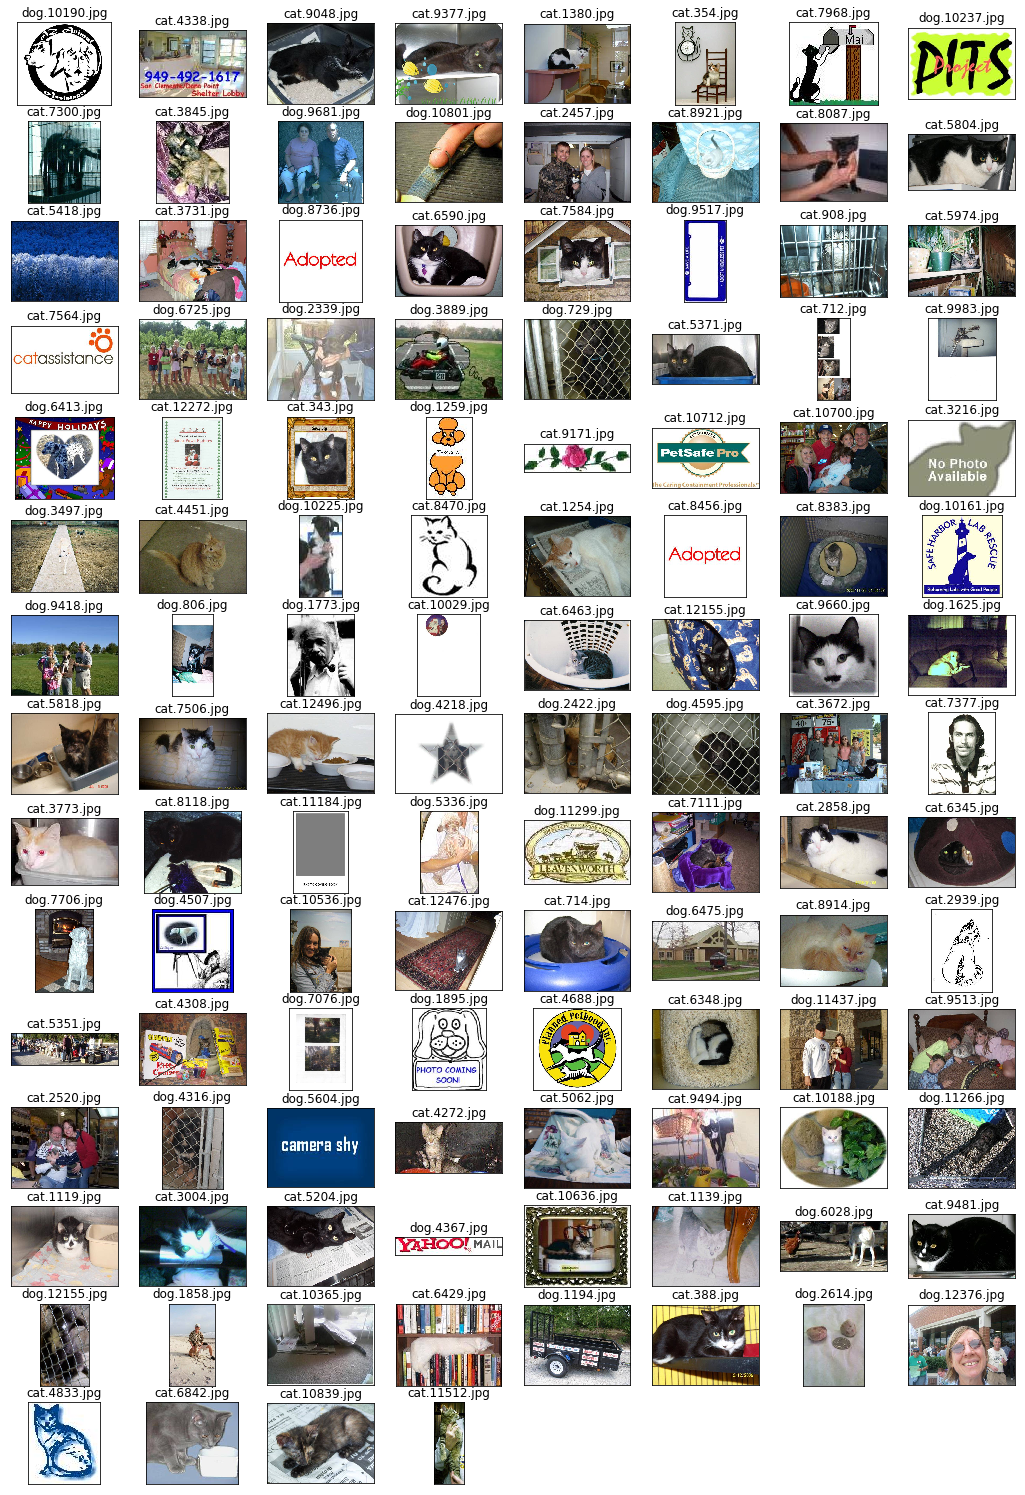

In [11]:
# 加载数据预览图片，resnet50 中预测到的异常图片
resnet50_check = Data_preprocessing.read_abnormal_file('abnormal_picture/resnet50_check.txt')
Data_preprocessing.preview_pictures(resnet50_check,train_dir,img_num=0,line_num=8,fig_size=(18,210))

preview picture num : 128


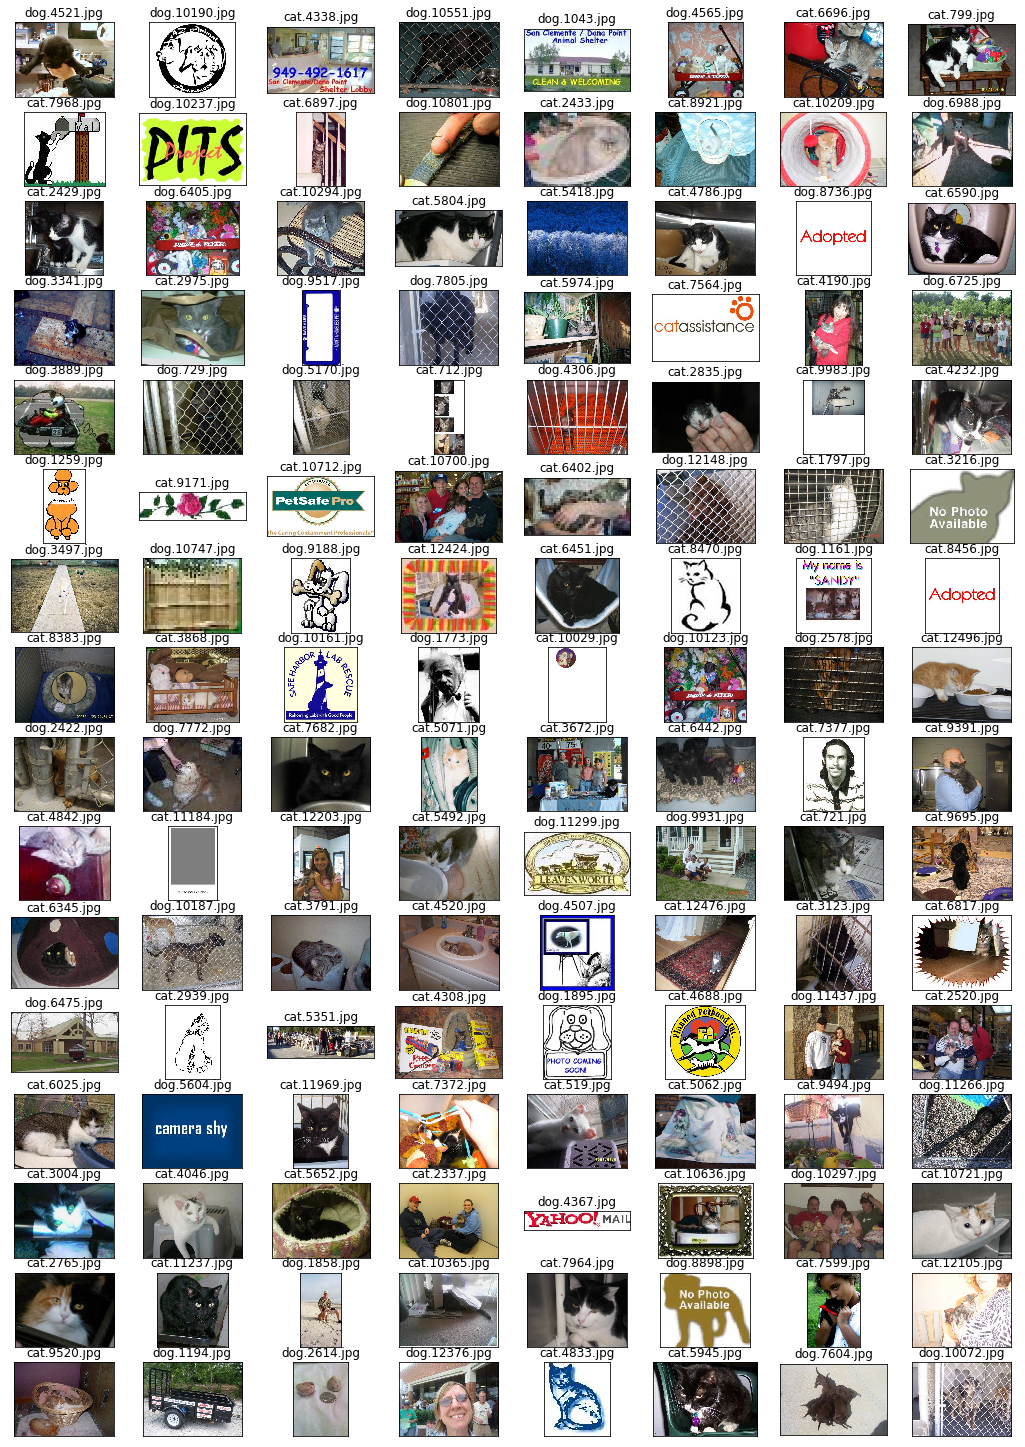

In [12]:
# 加载数据预览图片，xception 中预测到的异常图片
xception_check = Data_preprocessing.read_abnormal_file('abnormal_picture/xception_check.txt')
Data_preprocessing.preview_pictures(xception_check,train_dir,img_num=0,line_num=8,fig_size=(18,210))

Resnet 检测出116张异常图片，xception检测出128张异常图片。

可以看出resnet 和 xception 两种模型得到的异常图片，其中大部分是相同的。只有少部分不同。当然也有少量的几张图片可以通过人眼分析看出。但是对于25000张图片，可以暂时忽略。

#### 统计去除异常数据之后的数据情况

In [13]:
# 合并 resnet 和 xception 两个模型检测的异常数据
resnet50_check.extend(xception_check)
abnormal_image = set(resnet50_check)
Data_preprocessing.save_abnormal_picture("abnormal_image.txt",abnormal_image)

# 输出train数据集中 cat 和 dog 各自的图片数量（清理数据之后）
cat_counts = 0
dog_counts = 0
for file_name in os.listdir(train_dir):
    path = os.path.join(train_dir,file_name)
    if os.path.isdir(path):
        continue
    
    if file_name in abnormal_image:
        continue
        
    if file_name[:3] == 'cat':
        cat_counts += 1
        
    elif file_name[:3] == 'dog':
        dog_counts += 1

train_images_counts = 25000 - len(abnormal_image)
test_images_counts = 12500

print("Current dog counts: %d" %dog_counts)
print("Current cat counts: %d" %cat_counts)
print("train images counts: %d" %train_images_counts)
print("test images counts: %d" %test_images_counts)

save file success! file Dir : abnormal_picture
Current dog counts: 12437
Current cat counts: 12379
train images counts: 24816
test images counts: 12500


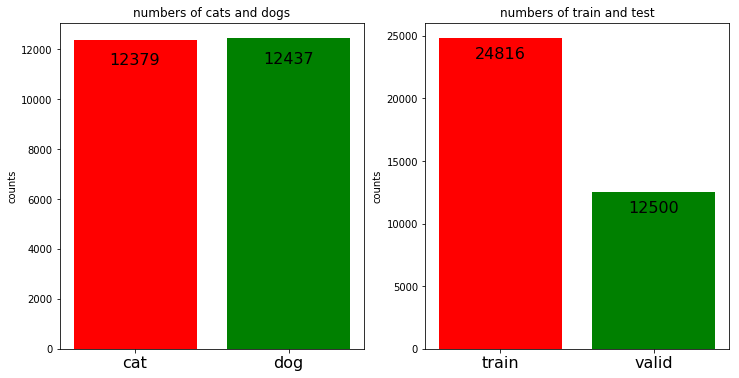

In [14]:
# 绘制统计图
plt.figure(figsize=(12,6))

# 绘制train数据集中猫和狗各自的数量
plt.subplot(1,2,1)
plt.bar(np.arange(1,3),[cat_counts,dog_counts],color='rgb')
plt.text(1,cat_counts-1000,str(cat_counts),fontsize=16,ha='center')
plt.text(2,dog_counts-1000,str(dog_counts),fontsize=16,ha='center')
plt.xticks(np.arange(1,3), ['cat','dog'],fontsize=16)
plt.ylabel("counts")
plt.title("numbers of cats and dogs")


# 绘制train和test数据集中各自的图片数量
plt.subplot(1,2,2)
plt.bar(np.arange(1,3),[train_images_counts,test_images_counts],color='rgb')
plt.text(1,train_images_counts-1600,str(train_images_counts),fontsize=16,ha='center')
plt.text(2,test_images_counts-1600,str(test_images_counts),fontsize=16,ha='center')
plt.xticks(np.arange(1,3), ['train','valid'],fontsize=16)
plt.ylabel("counts")
plt.title("numbers of train and test")

plt.show()

根据统计信息可以看出。在删除异常图片之后，train 数据集为24816。cat 的图片为12379，dog的图片为12437. 总共清理了184张异常图片

### 准备训练数据集

清理出异常数据之后，重新构建train训练数据集。由于目前使用的keras框架，在keras中，不同类型的图片需要用不同目录名进行存放。

如 trian-> cat -> cat.1.jpg 

这里选择在新建train，在新建的train目录下新建cat 和 dog 目录。这里采取软链接的形式进行操作。

In [15]:
# 新的图片数据目录
new_train_dir = '/data/dogs_vs_cats/data/new_train/'

In [16]:
# 剔除异常数据，对正常数据进行分类
train_cat = list()
train_dog = list()
for file_name in os.listdir(train_dir):
    path = os.path.join(train_dir,file_name)
    if os.path.isdir(path):
        continue
    
    if file_name in abnormal_image:
        continue
        
    if file_name[:3] == 'cat':
        train_cat.append(file_name)
        
    elif file_name[:3] == 'dog':
        train_dog.append(file_name)

# 创建软链接 (注意软连接目录名可以自动创建，如果路径存在，则注意保存目录下数据。否则可能会删除目录下的文件)
Data_preprocessing.create_symlink(train_dir,new_train_dir + 'cat',train_cat)
Data_preprocessing.create_symlink(train_dir,new_train_dir + 'dog',train_dog)

create symlink /data/dogs_vs_cats/data/new_train/cat success !
create symlink /data/dogs_vs_cats/data/new_train/dog success !


执行完成之后，文件目录结构如下：

![title](images/symlink1.png)

### 准备测试数据集

测试数据集跟训练数据集存储方式一样。同样是采取软连接的方式进行操作。test 数据集由于没有区分类别，所以暂时用test目录名

In [17]:
new_test_dir = '/data/dogs_vs_cats/data/new_test/'

In [18]:
Data_preprocessing.create_symlink(test_dir,new_test_dir + 'test',os.listdir(test_dir))

create symlink /data/dogs_vs_cats/data/new_test/test success !


执行完成之后，当前数据目录情况如下图。（下图提供参考理解，可能非实际情况）

![title](images/data-dir.png)

## 执行过程

（由于代码过多，这里将代码进行封装。详细的代码信息可在model_func.py 和 Data_preprocessing.py 文件进行查看）

### 数据增强

数据增强是指在原有的数据集上采用旋转、移动、翻转等相关手段对图片进行预处理。使用数据增强模式可以提供模型的泛化能力和提高模型的鲁棒性。

数据增强相关参考：https://blog.csdn.net/zhelong3205/article/details/81810743

在keras中提供 ImageDataGenerator 方法对图片数据进行预处理。可以使用该方法进行数据增强、缩放等预处理.

ImageDataGenerator 参考链接：https://keras.io/preprocessing/image/#imagedatagenerator-class

模型只有在训练过程中才需要使用数据增强，测试数据集中只需要对图片进行比例缩放即可。按比例缩放是对图片进行归一化处理，提供模型训练收敛。

In [19]:
from Data_preprocessing import Data_Generator

target_size = (224,224)
batch_size = 16

# 训练数据集进行数据增强模式
train_generator = Data_Generator(new_train_dir,target_size,batch_size,True)
# 测试数据集进行比例缩放
test_generator = Data_Generator(new_test_dir,target_size,batch_size,False)

Found 24816 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


### 使用resnet50提取特征向量

基于keras提供resnet50，采用迁移学习的方式构建和训练网络。在resnet50中提供了预训练的‘imagenet’权重模型。该模型包括了预先训练的1000个类，其中包括猫和狗。可在此基础上进行特征向量提取，并通过提取的特征向量构建网络进行训练。

使用预训练网络的bottleneck特征，可以快速提高准确率，节省缩短时间。

In [24]:
# 导入相关依赖包

from keras.models import Model
from keras.engine.input_layer import Input
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense,Dropout,Flatten
from keras.callbacks import ModelCheckpoint
from keras.utils import plot_model

from model_func import save_bottlebeck_features,get_bottlebeck_features
from model_func import plot_train_accuracy_and_loss

In [22]:
# 特征向量保存文件
resnet_bottlebeck_features = 'bottlebeck_features/resnet50_bottlebeck_features.h5py'

resnet_shape = (224,224,3)
batch_size = 16
target_size = (224,224)

# 保存特征向量
save_bottlebeck_features(input_shape=resnet_shape, 
                         train_gen=train_generator, 
                         test_gen=test_generator,
                         application_model=ResNet50, 
                         file_name=resnet_bottlebeck_features)

782/782 [==============================] - 49s 63ms/step
save bottlebeck features : bottlebeck_features/resnet50_bottlebeck_features.h5py


### 加载特征向量

In [25]:
X_train,X_test,y_train = get_bottlebeck_features([resnet_bottlebeck_features])

print("train shape:{}".format(X_train.shape))
print("test shape: {}".format(X_test.shape))
print("lable shape:{}".format(y_train.shape))

load bottlebeck_features/resnet50_bottlebeck_features.h5py ...
train shape:(24816, 2048)
test shape: (12500, 2048)
lable shape:(24816,)


### 构建模型

根据提取的特征向量可以看出属于二维向量，可构建全连接网络进行训练。

模型采用 rmsprop 优化器、binary_crossentropy 损失函数。

rmsprop 为神经网络较为适用的优化器。当然也有其他比较优秀的优化器，如：adam、SGD 等等。优化器选择可以参考：https://www.cnblogs.com/guoyaohua/p/8542554.html

binary_cross_entropy是二分类的交叉熵，实际是多分类softmax_cross_entropy的一种特殊情况，当多分类中，类别只有两类时，即0或者1，即为二分类，二分类也是一个逻辑回归问题，也可以套用逻辑回归的损失函数。

In [36]:
input_layer = Input(X_train.shape[1:])
model = input_layer
model = Dropout(0.5)(model)
model = Dense(512,activation='relu')(model)
model = Dropout(0.5)(model)
model = Dense(1,activation='sigmoid')(model)

model = Model(input_layer,model)

model.compile(optimizer='rmsprop',loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 513       
Total params: 1,049,601
Trainable params: 1,049,601
Non-trainable params: 0
_________________________________________________________________


### 训练模型

定义训练的轮数为30，并保存最佳训练模型

In [37]:
epochs = 30

resnet50_checkpoint = ModelCheckpoint(filepath="model/resnet50_dogs_vs_cats_best_model.hdf5",
                                      verbose=1,save_best_only=True)

history = model.fit(X_train,y_train,
                    batch_size=32,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[resnet50_checkpoint],
                    validation_split=0.2)

Train on 19852 samples, validate on 4964 samples
Epoch 1/30
19852/19852 [==============================] - 5s 233us/step - loss: 0.7256 - acc: 0.5310 - val_loss: 0.6752 - val_acc: 0.6023

Epoch 00001: val_loss improved from inf to 0.67516, saving model to model/resnet50_dogs_vs_cats_best_model.hdf5
Epoch 2/30
19852/19852 [==============================] - 2s 109us/step - loss: 0.6864 - acc: 0.5595 - val_loss: 0.6681 - val_acc: 0.6019

Epoch 00002: val_loss improved from 0.67516 to 0.66813, saving model to model/resnet50_dogs_vs_cats_best_model.hdf5
Epoch 3/30
19852/19852 [==============================] - 2s 108us/step - loss: 0.6811 - acc: 0.5678 - val_loss: 0.6649 - val_acc: 0.5997

Epoch 00003: val_loss improved from 0.66813 to 0.66494, saving model to model/resnet50_dogs_vs_cats_best_model.hdf5
Epoch 4/30
19852/19852 [==============================] - 2s 109us/step - loss: 0.6799 - acc: 0.5663 - val_loss: 0.6691 - val_acc: 0.5822

Epoch 00004: val_loss did not improve from 0.66494


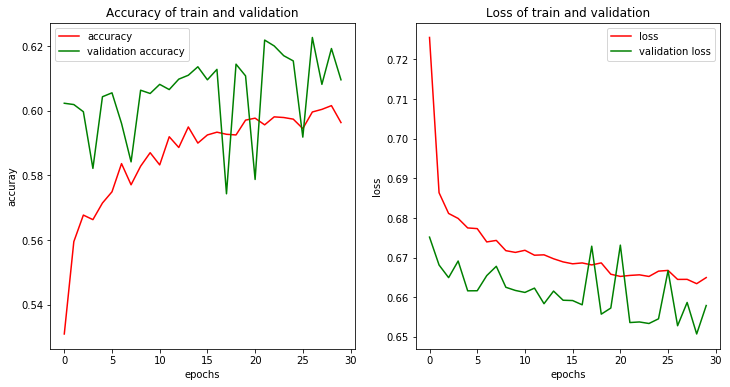

In [38]:
# 绘制 accuracy 和 loss 曲线
plot_train_accuracy_and_loss(history)

* 根据输出信息，在 resnet50 上采用迁移学习的方式训练模型,模型并未达到理想要求。可能是提取的特征向量不足，参数不足等。这里参考网络上提供的一种[方法](https://blog.csdn.net/shizhengxin123/article/details/72473245)来提高准确率，采用resnet与其他方法融合的方式提高准确率。

其方法核心是利用 [Boosting](https://www.cnblogs.com/liuwu265/p/4690486.html) 思想。将resnet模型与其他模型进行融合共同提取图片特征，之后构建网络进行训练来提高准确率。

### 使用其他模型提取特征向量

这里将采用keras 提供的resnet50、xception、InceptionV3 三种比较常见的神经网络构建模型，利用三种网络模型进行特征向量提取，将提取的特征向量进行组合训练。以此提高 accuracy 和降低 loss 。



In [39]:
# 特征向量保存文件
InceptionV3_bottlebeck_features = 'bottlebeck_features/InceptionV3_bottlebeck_features.h5py'
xception_bottlebeck_features = 'bottlebeck_features/xception_bottlebeck_features.h5py'

In [40]:
# 使用InceptionV3提取瓶颈特征
from keras.applications.inception_v3 import InceptionV3

inception_shape = (299,299,3)
batch_size = 16
target_size = (299,299)

# 训练数据进行增强处理 
inception_train_generator = Data_Generator(new_train_dir,target_size,batch_size,True)
# 测试数据进行缩放比例[0，255]
inception_test_generator = Data_Generator(new_test_dir,target_size,batch_size,False)

save_bottlebeck_features(input_shape=inception_shape, 
                         train_gen=inception_train_generator, 
                         test_gen=inception_test_generator,
                         application_model=InceptionV3, 
                         file_name=InceptionV3_bottlebeck_features)

Found 24816 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
782/782 [==============================] - 47s 60ms/step
save bottlebeck features : bottlebeck_features/InceptionV3_bottlebeck_features.h5py


In [41]:
# 使用xception提取瓶颈特征
from keras.applications.xception import Xception 

xception_shape = (299,299,3)
batch_size = 16
target_size = (299,299)

# 训练数据进行增强处理 
xception_train_generator = Data_Generator(new_train_dir,target_size,batch_size,True)
# 测试数据进行缩放比例[0，255]
xception_test_generator = Data_Generator(new_test_dir,target_size,batch_size,False)

save_bottlebeck_features(input_shape=xception_shape, 
                         train_gen=xception_train_generator, 
                         test_gen=xception_test_generator,
                         application_model=Xception, 
                         file_name=xception_bottlebeck_features)

Found 24816 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
782/782 [==============================] - 51s 65ms/step
save bottlebeck features : bottlebeck_features/xception_bottlebeck_features.h5py


#### 加载特征向量

In [42]:
from model_func import get_bottlebeck_features

features_list = [resnet_bottlebeck_features,InceptionV3_bottlebeck_features,xception_bottlebeck_features]

X_train,X_test,y_train = get_bottlebeck_features(features_list)

load bottlebeck_features/resnet50_bottlebeck_features.h5py ...
load bottlebeck_features/InceptionV3_bottlebeck_features.h5py ...
load bottlebeck_features/xception_bottlebeck_features.h5py ...


In [43]:
print("train shape : {}".format(X_train.shape))
print("test shape :  {}".format(X_test.shape))
print("label shape : {}".format(y_train.shape))

train shape : (24816, 6144)
test shape :  (12500, 6144)
label shape : (24816,)


### 创建模型

这里模型需要重新创建。原因是采用InceptionV3、 xception、resnet50 进行特征提取之后。提取特征向量输出层的shape不在是(1,2048)，而是(1,6144)。这里模型需要重新创建，指定输入层shape为(1,6144)。

提取特征向量之后，构建神经网络。神经网络中使用relu、sigmoid 作为激活函数，rmsprop 为优化器，dropout为0.5。输出一个零维张量，表示某张图片中有狗的概率。损失函数为 binary_crossentropy。

In [44]:
from model_func import create_model

model = create_model(X_train,drop_out=0.5,optimizer='rmsprop')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 6144)              0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 6144)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 512)               3146240   
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 3,146,753
Trainable params: 3,146,753
Non-trainable params: 0
_________________________________________________________________


### 训练模型

对构建的模型进行训练，指定训练轮数为30,batch_size为32，验证数据百分数为0.2

In [45]:
from model_func import train_model

epochs=25
valid_split = 0.2
checkpoint = 'model/dogs_vs_cats_best_model.hdf5'

history = train_model(model,X_train,y_train,checkpoint,
                      batch_size=32,n_epochs=epochs,verbose=2,valid_split=valid_split)

Train on 19852 samples, validate on 4964 samples
Epoch 1/25
 - 8s - loss: 0.2119 - acc: 0.9703 - val_loss: 0.0225 - val_acc: 0.9960

Epoch 00001: val_loss improved from inf to 0.02251, saving model to model/dogs_vs_cats_best_model.hdf5
Epoch 2/25
 - 3s - loss: 0.0802 - acc: 0.9868 - val_loss: 0.0265 - val_acc: 0.9962

Epoch 00002: val_loss did not improve from 0.02251
Epoch 3/25
 - 3s - loss: 0.0798 - acc: 0.9893 - val_loss: 0.0299 - val_acc: 0.9960

Epoch 00003: val_loss did not improve from 0.02251
Epoch 4/25
 - 3s - loss: 0.0897 - acc: 0.9888 - val_loss: 0.0543 - val_acc: 0.9927

Epoch 00004: val_loss did not improve from 0.02251
Epoch 5/25
 - 3s - loss: 0.0955 - acc: 0.9895 - val_loss: 0.0262 - val_acc: 0.9968

Epoch 00005: val_loss did not improve from 0.02251
Epoch 6/25
 - 3s - loss: 0.0870 - acc: 0.9901 - val_loss: 0.0368 - val_acc: 0.9954

Epoch 00006: val_loss did not improve from 0.02251
Epoch 7/25
 - 3s - loss: 0.0784 - acc: 0.9911 - val_loss: 0.0299 - val_acc: 0.9956

Epoch

### 绘制准确率和损失曲线

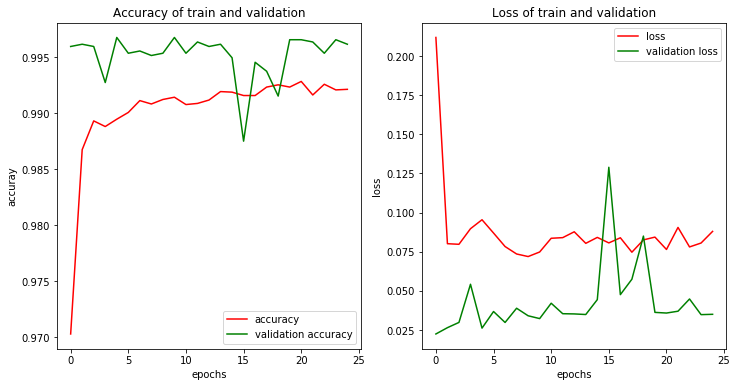

In [46]:
from model_func import plot_train_accuracy_and_loss

plot_train_accuracy_and_loss(history)

由图可以看出准确率比较高。基本上在0.99以上，平均稳定在0.990到0.995之间。与此对应的loss ,平均稳定在 0.075 和 0.025之间

### 预测图片

根据kaggle中项目的要求，将测试数据集的结果保存到csv文件中，并上传评分。

In [47]:
# 加载最佳模型
model.load_weights(checkpoint)

# 对测试数据进行预测，保存预测结果
predict_value = model.predict(X_test,verbose=1)

# 剪辑出区间值。
predict_value = predict_value.clip(min=0.005,max=0.995)

12500/12500 [==============================] - 3s 227us/step


In [48]:
from model_func import save_csv

save_csv(predict_value,test_generator,csv_file='/data/sample_submission.csv',
         pred_file='predict_dogs_vs_cats.csv')

save csv file : predict_dogs_vs_cats.csv


/home/aind2/project/dogs_vs_cats/model_func.py:183: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index,'label',y_pred[i])


将保存在当前目录下 predict_dogs_vs_cats.csv 文件上传到kaggle，并获取得分

## 完善

异常数据的清理，可适当的增加或减少top值，也许可以清理出更多的异常图片。当然还可以加入 InceptionV3，使用InceptionV3 与目前的resnet50、xception 一起进行数据清理。也许可以清理出更多的异常图片。

尝试使用adam优化器。Adam优化器是目前比较热门的一种优化算法。关于它的相关资料可参考该[博客](https://www.cnblogs.com/guoyaohua/p/8542554.html) 
 
 在原先resnet50的基础上尝试其他方法来获取精度。如采用迁移学习的另一种方式，在resnet50的基础上，删除全连接层，根据需要构建全连接层，然后训练整个神经网络，通过此方式也可提高模型的精度。也是一种方法。

# IV.结果

## 模型评价与验证

### 模型训练 accuracy 和 loss 曲线

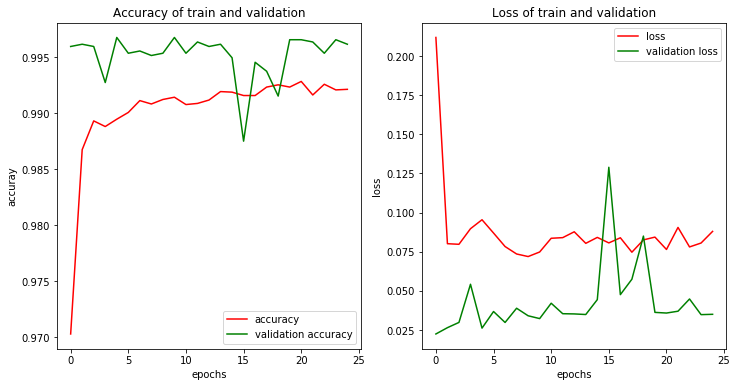

In [49]:
plot_train_accuracy_and_loss(history)

* 根据模型的输出和 accuracy 、loss 曲线图。模型训练和验证 accuracy 平均维持在0.990～0.995左右，验证和训练 loss 在0.075～0.025 左右。相对还是比较高。

### kaggle 得分

从上获取到的评分为：，已经达到目标要求。

![title](images/kaggle-score.png)

## 合理性分析

通过迁移学习可以将快速的提高模型精度。这里先采取了resnet50 模型进行特征提取。获得最佳accuracy 和 loss 分别是：

Total params: 1,049,601

loss：0.6634  validaction loss：0.6507 

仅采用resnet50获取到的精度并不理想，这里结合额外的两种模型 InceptionV3 和 xception 共同提取特征向量。获取到的模型精度为：

Total params: 3,146,753

loss：0.2119  validaction loss：0.0225

采用xception、inception、resnet50 组合提取特征向量。效果比仅使用resnet50要好。原始的 Xception 有 126 层，InceptionV3 有 159 层，ResNet50 有 168 层，更多的层数，不同的卷积核各种各样的的组合，可以更好的抽取图片中的泛化特征，这样既可以提高分类的准确率，又可以降低模型的过拟合风险


# V.项目结论

## 结果可视化

加载最佳模型，使用最佳模型对图片进行预测，输出预测结果

In [51]:
# 抽取随机数,从测试集中随机抽取图片
random_index = np.random.choice(len(os.listdir(test_dir)),24)
random_index

array([ 8902,  8613, 11712, 11881,  4936,  8100,  9414,   662,  5804,
       11743,   210,  7398,  7997,  4022,  3089, 11615,  7865,  8934,
        6341,  2286, 11591,  8083, 11648,  9664])

In [73]:
# 加载最佳模型
model.load_weights(checkpoint)

# 对测试数据进行预测，保存预测结果
predict_value = model.predict(X_test,verbose=1)

# 剪辑出区间值。
predict_value = predict_value.clip(min=0.005,max=0.995)

12500/12500 [==============================] - 1s 64us/step


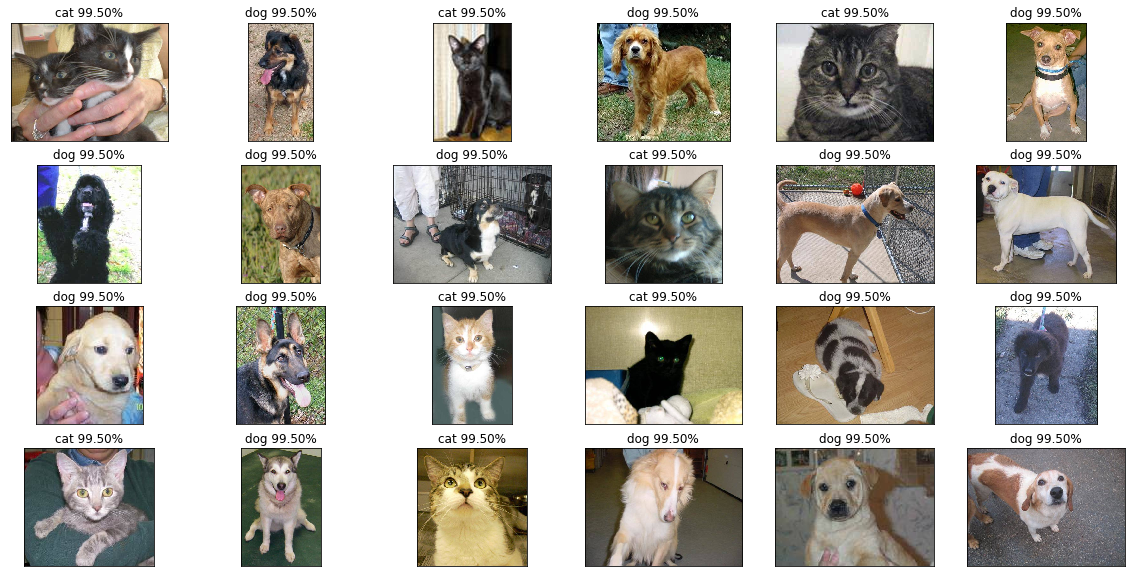

In [83]:
# 对随机生成的图片进行预测
preview_image = list()
predict_result = list()

img_name = test_generator.filenames

for index in random_index:
    
    #print(predict_value[index][0])
    
    if predict_value[index] >= 0.5:
        predict_result.append("dog {:.2f}%".format(predict_value[index][0] * 100))
    else:
        predict_result.append("cat {:.2f}%".format((1 - predict_value[index][0]) * 100))
    
    # 图片转换为可用matplotlib 预览的格式
    img = cv_read_image(os.path.join(new_test_dir,img_name[index]))
    preview_image.append(img)

# 显示随机选取的图片
fig = plt.figure(figsize=(20,10))
for i in range(len(preview_image)):
    ax = fig.add_subplot(4,6,i+1,xticks=[],yticks=[])
    ax.imshow(preview_image[i])
    ax.set_title(predict_result[i])
    
plt.show()

## 对项目的思考


项目采用的训练环境是aws上的p3.2xargs云服务器。整个项目训练不超过5个小时，总体上还是比较快的。但是在完成项目过程中需要进行多次尝试，多次修改。整个过程可谓漫长而充满乐趣。

深度学习毫无疑问是处理图像的最佳模型，或许可以在后期尝试构建神经网络，通过不断的加深网络来提高精度、使用正则化、BN防止过拟合、尝试选择其他优化器。adam 目前是比较热门的一个优化器。或许自构建的神经网络可以达到不一样的效果。

项目中使用三种模型提取特征向量很快提高了准确率。但需要注意特征向量的组合，组合的顺序不对，预测就会出现极大的误差。同时预测一张图片需要同时使用三个模型提取特征向量，这无疑比较缓慢，比较耗费时间。

## 需要作出的改进

针对目前的项目，个人认为需要作出改进主要有以下几点：

（1）优化项目程序。对于项目中的一些程序和算法做优化处理。

（2）异常图片的清理。项目中仅使用了resnet50、xception 两种模型进行异常数据的检验。共检验出异常数据 184 张。当然其中有部分图片人眼可以预览。但是不排除还有其他异常图片。可加入inception 模型进行检验，或许能检验出更多的异常数据。

（3）项目中采用的keras网络框架。目前tensorflow、pytorch 网络框架也比较推荐。keras 相比较而言使用比较方便，但效率比 tensorflow 慢很多。同时网络上推荐使用的 pytorch 不仅有tensorflow高效率，而且可以在任意层和numpy数组进行转换。

## 项目部署

 项目使用keras和flask搭建部署一个简单的网页应用。可以通过网页上传一张猫或者狗的彩色图片，预测彩色图片是中猫或狗的类别、以及概率。

### 项目目录结构：

![title](images/webapp-dir.png)

web_app.py --> 应用程序文件。使用py web_app.py 启动服务

config.py  --> 为应用的配置文件。可在此配置文件中修改监听端口、训练模型路径、上传图片存储路径等。具体查看文件内说明

dogs_vs_cats_linux.yml --> 搭建环境文件。可使用conda 执行搭建环境

dogs_vs_cats_linux-pip.txt --> 环境中使用的相关依赖库

项目训练的 model 可在此百度网盘上下载（限国内网络）：https://pan.baidu.com/s/1yKbKrmMybfnz04I_1usnFw 

github 访问：https://github.com/boyshen/cv-project

### 搭建环境

创建环境

####  # conda env create -f dogs_vs_cats_linux.yml

激活环境

#### # source activate dogs_vs_cats 

安装相关库

#### # pip install -r dogs_vs_cats_linux-pip.txt

### 启动服务

#### # python web_app.py

注意在config.py 文件查看端口。默认端口是8888（可修改），监听网络地址为 0.0.0.0 即所有。

服务启动之后。在浏览器中输入 http://服务器IP地址:端口 即可访问。如：http://192.168.10.22:8888

下图为预测效果图片：

![title](images/web_predict.gif)

# V.参考文献

[1] [Deep Residual Learning for Image Recognition Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun](https://arxiv.org/abs/1512.03385)

[2] [Convolutional neural network From Wikipedia, the free encyclopedia](https://en.wikipedia.org/wiki/Convolutional_neural_network)

[3] [Dogs vs Cats For Udacity (异常值检验)](https://zhuanlan.zhihu.com/p/34068451)

[4] [深度学习-优化器算法详解](https://www.cnblogs.com/guoyaohua/p/8542554.html)

[5] [Dogs vs. Cats: Image Classification with Deep Learning using TensorFlow in Python](https://www.datasciencecentral.com/profiles/blogs/dogs-vs-cats-image-classification-with-deep-learning-using)

[6] [CatdogNet - Keras Convnet Starter](https://www.kaggle.com/jeffd23/catdognet-keras-convnet-starter)

[7] [CNN Architectures : VGG, ResNet, Inception + TL](https://www.kaggle.com/shivamb/cnn-architectures-vgg-resnet-inception-tl)

[8] [Dogs vs Cats: Keras Solution](https://www.kaggle.com/sarvajna/dogs-vs-cats-keras-solution)

[9] [Kaggle猫狗大战准确率Top 2%webapp部署](https://www.jianshu.com/p/1bc2abe88388)

[10] [Keras: 基于python的深度学习](https://keras.io/zh/)

[11] [利用resnet 做kaggle猫狗大战图像识别，秒上98准确率](https://blog.csdn.net/shizhengxin123/article/details/72473245)
